In [1]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 1)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.layer4 = self.make_layer(block, 128, layers[1], 1)
        self.max_pool = torch.nn.MaxPool2d(8)
        self.fc = torch.nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
net = torch.load('/home/matvey/Morozov/Научрук/Диплом/Diploma-Thesis/Модель/Models/FashionMNIST_ResNet.pth', map_location=torch.device('cpu'))
net = net.to('cpu')
net.eval()

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [5]:
test_tf = transforms.Compose([
    transforms.ToTensor()
])

test = torchvision.datasets.FashionMNIST('/home/matvey/Morozov/Научрук/Диплом/Diploma-Thesis/Модель/Datasets', download=False, train=False, transform=test_tf)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=256, shuffle=False)

In [6]:
labels = {
0 : 'T-shirt/top',
1 : 'Trouser',
2 : 'Pullover',
3 : 'Dress',
4 : 'Coat',
5 : 'Sandal',
6 : 'Shirt',
7 : 'Sneaker',
8 : 'Bag',
9 : 'Ankle boot'
}

In [7]:
from numpy.linalg import norm
from scipy.special import softmax

examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

## SimBA

In [8]:
from SimBA import simba_single

In [9]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 1, 28, 28)).data.numpy()[0])

    x, difference = simba_single(net, example_data[i].reshape(1,1,28,28), example_targets[i].reshape(-1), epsilon=5e-2, name='mnist')
    prob_adv = softmax(net(x.reshape(1, 1, 28, 28)).data.numpy()[0])
    
    fig, axes = plt.subplots(figsize=[14, 14])

    init_image = example.data.numpy()[0]
    adv_image = x.data.numpy()[0][0]
    difference = difference.data.numpy()[0][0]
    
    plt.subplot(141)    
    plt.imshow(init_image, cmap='gray')
    plt.title('Original ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_original)]) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    plt.subplot(142)
    plt.imshow(adv_image, cmap='gray')
    plt.title('Adversarial ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_adv)]) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))
    
    plt.subplot(143)
    
    plt.imshow(difference, cmap='gray', vmax=1.)
    plt.title('Difference' + '\n' + str(np.linalg.norm(difference)))
    
    plt.subplot(144)
    
    plt.imshow(difference, cmap='gray')
    plt.title('Scaled difference' + '\n' + str(np.linalg.norm(difference)))

    plt.show()

Start simple black-box attack...
Iteration: 154, epsilon: 0.05000, probability: 0.999, init_label: 9, adv_label: 9, distance: 0.550000

KeyboardInterrupt: 

## Fast gradient sign method

In [10]:
from FGSM import fgsm_attack

Start fast gradient sign attack...
Iteration: 371, epsilon: 0.037, init_label: 9, adv_label: 8
Attack is succesful!


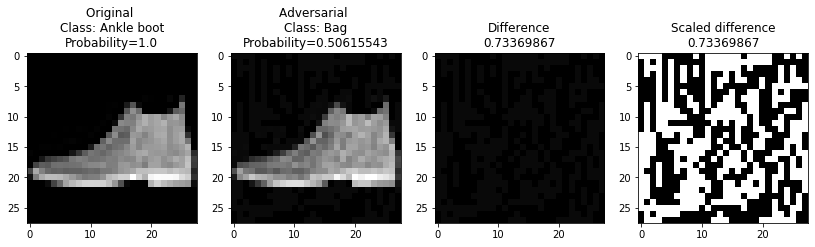

Start fast gradient sign attack...
Iteration: 104, epsilon: 0.010, init_label: 2, adv_label: 6
Attack is succesful!


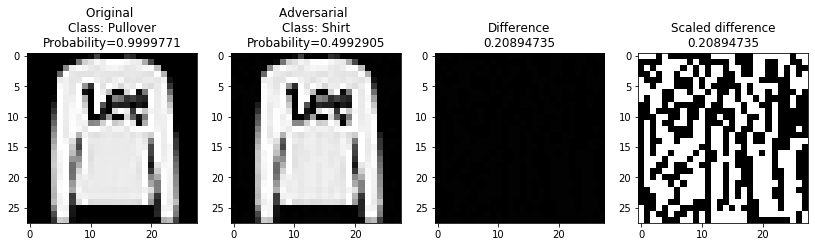

Start fast gradient sign attack...
Iteration: 1480, epsilon: 0.148, init_label: 1, adv_label: 6
Attack is succesful!


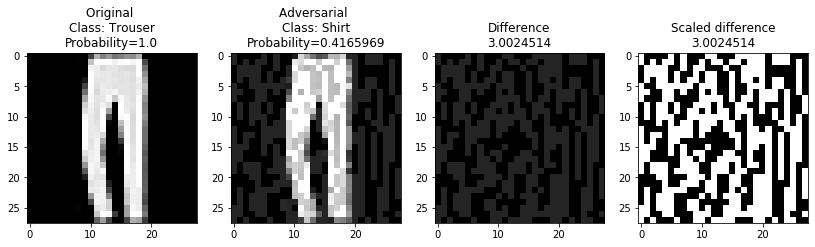

Start fast gradient sign attack...
Iteration: 668, epsilon: 0.067, init_label: 1, adv_label: 3
Attack is succesful!


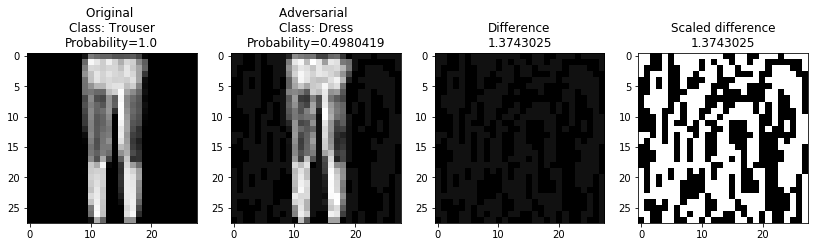

Start fast gradient sign attack...
Iteration: 27, epsilon: 0.003, init_label: 6, adv_label: 0
Attack is succesful!


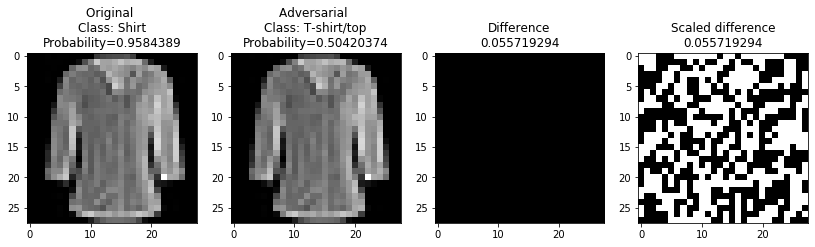

In [11]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 1, 28, 28)).data.numpy()[0])

    x, difference = fgsm_attack(net, example_data[i].reshape(1,1,28,28), example_targets[i].reshape(-1), 1e-4)
    prob_adv = softmax(net(x.reshape(1, 1, 28, 28)).data.numpy()[0])
    
    fig, axes = plt.subplots(figsize=[14, 14])

    init_image = example.data.numpy()[0]
    adv_image = x.data.numpy()[0][0]
    difference = difference.data.numpy()[0][0]
    
    plt.subplot(141)    
    plt.imshow(init_image, cmap='gray')
    plt.title('Original ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_original)]) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    plt.subplot(142)
    plt.imshow(adv_image, cmap='gray')
    plt.title('Adversarial ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_adv)]) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))
    
    plt.subplot(143)
    
    plt.imshow(difference, cmap='gray', vmax=1.)
    plt.title('Difference' + '\n' + str(np.linalg.norm(difference)))
    
    plt.subplot(144)
    
    plt.imshow(difference, cmap='gray')
    plt.title('Scaled difference' + '\n' + str(np.linalg.norm(difference)))

    plt.show()

## Iterative Fast gradient sign method.

In [12]:
from IFGSM import ifgsm_attack

Start ITERATIVE fast gradient sign attack...
Iteration: 138, epsilon: 0.00010, init_label: 9, adv_label: 7
Attack is succesful!


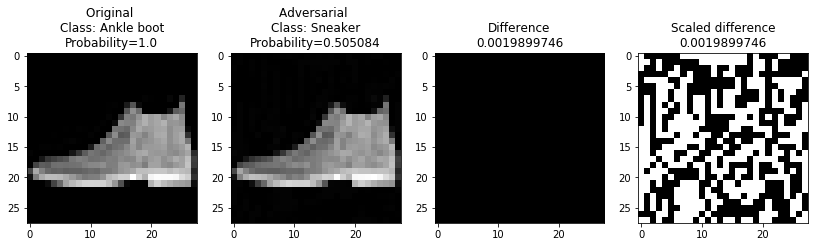

Start ITERATIVE fast gradient sign attack...
Iteration: 65, epsilon: 0.00010, init_label: 2, adv_label: 6
Attack is succesful!


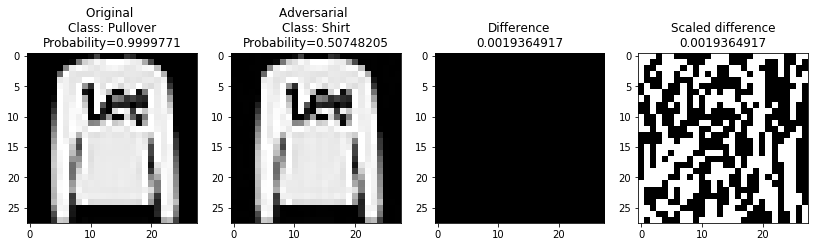

Start ITERATIVE fast gradient sign attack...
Iteration: 386, epsilon: 0.00010, init_label: 1, adv_label: 3
Attack is succesful!


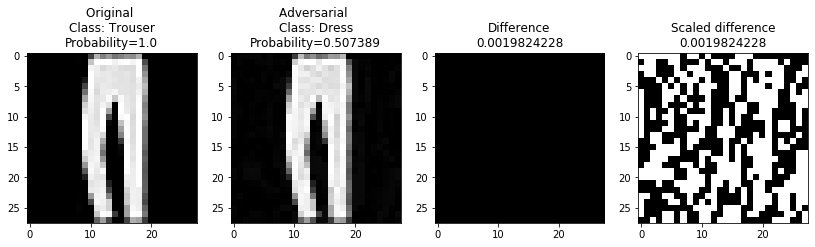

Start ITERATIVE fast gradient sign attack...
Iteration: 295, epsilon: 0.00010, init_label: 1, adv_label: 3
Attack is succesful!


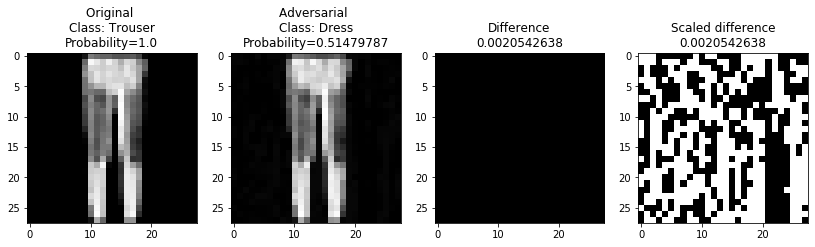

Start ITERATIVE fast gradient sign attack...
Iteration: 26, epsilon: 0.00010, init_label: 6, adv_label: 0
Attack is succesful!


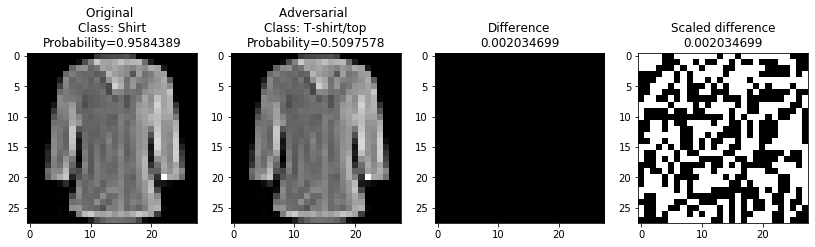

In [13]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 1, 28, 28)).data.numpy()[0])

    x, difference = ifgsm_attack(net, example_data[i].reshape(1,1,28,28), example_targets[i].reshape(-1), 1e-4)
    prob_adv = softmax(net(x.reshape(1, 1, 28, 28)).data.numpy()[0])
    
    fig, axes = plt.subplots(figsize=[14, 14])

    init_image = example.data.numpy()[0]
    adv_image = x.data.numpy()[0][0]
    difference = difference.data.numpy()[0][0]
    
    plt.subplot(141)    
    plt.imshow(init_image, cmap='gray')
    plt.title('Original ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_original)]) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    plt.subplot(142)
    plt.imshow(adv_image, cmap='gray')
    plt.title('Adversarial ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_adv)]) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))
    
    plt.subplot(143)
    
    plt.imshow(difference, cmap='gray', vmax=1.)
    plt.title('Difference' + '\n' + str(np.linalg.norm(difference)))
    
    plt.subplot(144)
    
    plt.imshow(difference, cmap='gray')
    plt.title('Scaled difference' + '\n' + str(np.linalg.norm(difference)))

    plt.show()

##  Boundary Attack and Boundary Attack MCMC

In [8]:
from boundary_MCMC import boundary_attack_MCMC
from boundary import boundary_attack

### Target example

In [9]:
x_init = example_data[5].reshape(28, 28)
x_init = x_init.data.numpy()

In [10]:
pred = net(torch.tensor(x_init.reshape(1,1,28,28)).to(dtype=torch.float))
print(np.argmax((pred.data.numpy())[0]))

1


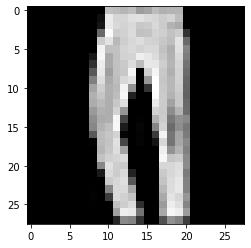

In [11]:
plt.imshow(x_init, cmap='gray')

### Attacked example

In [12]:
x_target = example_data[0].reshape(28, 28)
x_target = x_target.data.numpy()

In [13]:
pred = net(torch.tensor(x_target.reshape(1,1,28,28)).to(dtype=torch.float))
print(np.argmax((pred.data.numpy())[0]))

9


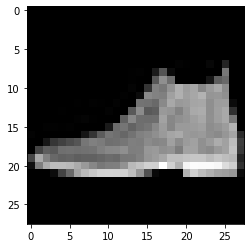

In [14]:
plt.imshow(x_target, cmap='gray')

### Boundary MCMC

In [15]:
adv_example, proba = boundary_attack_MCMC(net, x_init, x_target, threshold=0.3, verbose=1)

Start boundary attack
distance: 0.2989, itetarion: 162, alpha: 0.817, probability: 0.545

In [16]:
print(proba)

0.5449248


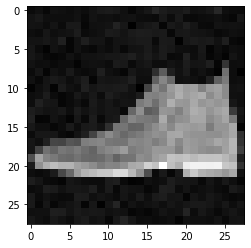

In [17]:
plt.imshow(adv_example, cmap='gray')

In [18]:
pred = net(torch.tensor(adv_example.reshape(1,1,28,28)).to(dtype=torch.float))
print(np.argmax((pred.data.cpu().numpy())[0]))

1


### Boundary

In [19]:
adv_example, proba = boundary_attack(net, x_init, x_target, threshold=0.3, verbose=1)

Start boundary attack
distance: 0.2995, itetarion: 172

In [20]:
print(proba)

0.4492731


In [ ]:
from scipy.special import softmax

# Сравнение алгоритмов

1. SimBA
2. Fast gradient method
3. Iterative fast gradient method
4. Boundary attack
5. Out method

Посчитаем средние расстояния от исходных объектов до адверсальных примеров, по l1 и l2 норме. Будем смотреть около 50 первых объектов из тестовой выборки.

#### SimBA

In [ ]:
def normalize(x):
    return utils.apply_normalization(x, 'MNIST')

def get_probs(model, x, y):
    output = model(normalize(x.cuda())).cpu()
    probs = torch.nn.Softmax()(output)[:, y]
    return torch.diag(probs.data)

In [ ]:
def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    
    init_label = np.argmax(model(x.cuda()).data.cpu().numpy())
    
    iteration = 0
    eps_init = epsilon
    iter_number = 1
    
    while True:
        diff = torch.zeros(n_dims)

        diff[torch.randint(0, 28*28, (iter_number,))] = epsilon

        left_prob = get_probs(model, (x - diff.view(x.size()).to(device)).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size()).to(device)).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs(model, (x + diff.view(x.size()).to(device)).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size()).to(device)).clamp(0, 1)
                last_prob = right_prob
        
        adv_label = np.argmax(model(x.cuda()).data.cpu().numpy())
        
        sys.stdout.write("\rsample: %d, iteration: %d, eps: %0.3f" % (i, iteration, epsilon))
        sys.stdout.flush()
        
        if iteration%1000==0 and iteration>0:
            epsilon += 0.025
            
        if (iteration%3000==0 and iteration>0):
            iter_number += 15            
            
        if epsilon > 0.8:
            epsilon = eps_init
            iter_number += 15
        
        if adv_label != init_label:
            break
            
        if iteration > 20000:
            break
        
        iteration += 1
        
    return x

In [ ]:
l1_SBA = []
l2_SBA = []

In [ ]:
for i in range(60):
    if (example_targets[i].data.cpu().numpy() != 1):
        example = example_data[i]
        x = simba_single(net, example.reshape(1, 1, 28, 28).to(device), torch.tensor(example_targets[i]).to(device), epsilon=0.025)
        init_image = example.data.cpu().numpy()[0]
        adv_image = x.data.cpu().numpy()[0][0]

        l1 = np.linalg.norm(init_image - adv_image, ord=1)
        l2 = np.linalg.norm(init_image - adv_image, ord=2)

        l1_SBA.append(l1)
        l2_SBA.append(l2)

In [ ]:
print('Среднее расстояние по l1', np.mean(l1_SBA))
print('Среднее расстояние по l2', np.mean(l2_SBA))

#### Fast Gradient Method

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    init_label = np.argmax(net(image.cuda()).data.cpu().numpy())
    
    iteration = 0
    
    while True:
        sign_data_grad = data_grad.sign()
        perturbed_image = image + epsilon * sign_data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        adv_label = np.argmax(net(perturbed_image.cuda()).data.cpu().numpy())
        
        if init_label != adv_label:
            break
        
        epsilon *= 1.05
        
        iteration += 1
        
        if iteration > 100:
            break
    
    return perturbed_image

In [ ]:
loss = torch.nn.CrossEntropyLoss()
example_data, example_targets = example_data.to(device), example_targets.to(device)
example_data.requires_grad = True
output = net(example_data)

loss_val = loss(output, example_targets)

net.zero_grad()
loss_val.backward()

data_grad = example_data.grad.data

In [ ]:
l1_FGM = []
l2_FGM = []

In [ ]:
for i in range(60):
    if (example_targets[i].data.cpu().numpy() != 1):
        example = example_data[i]
        x = fgsm_attack(example.reshape(1, 1,28,28), 0.01, data_grad[i])

        init_image = example.data.cpu().numpy()[0][0]
        adv_image = x.data.cpu().numpy()[0][0]

        l1 = norm(init_image - adv_image, ord=1)    
        l2 = norm(init_image - adv_image, ord=2)

        l1_FGM.append(l1)
        l2_FGM.append(l2)

        sys.stdout.write("\rIteration: %d" % (i, ))

In [ ]:
print('Среднее расстояние по l1', np.mean(l1_FGM))
print('Среднее расстояние по l2', np.mean(l2_FGM))

#### Iterative Fast Gradient Method

In [ ]:
l1_IFGM = []
l2_IFGM = []

In [ ]:
torch.retain_graph=True
loss_val = loss(output, example_targets)

In [ ]:
def ifgsm_attack(example_data, example_targets, net, loss, epsilon, iteration=1):
    example_data_copy = example_data
    
    init_label = np.argmax(net(example_data.cuda()).data.cpu().numpy(), axis=1)
    iteration = 0
    
    while True:
        output = net(example_data)
        loss_val = loss(output, example_targets)

        net.zero_grad()
        loss_val.backward()
        data_grad = example_data.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_images = example_data + epsilon*sign_data_grad
        perturbed_images = torch.clamp(perturbed_images, 0, 1)     
        example_data = torch.tensor(perturbed_images, requires_grad=True)
        
        adv_label = np.argmax((net(perturbed_images.cuda()).data.cpu().numpy()), axis=1)
        
        if iteration > 100:
            break
            
        iteration += 1

    example_data = example_data_copy
        
    return perturbed_images

In [ ]:
retain_graph=True
perturbed_images = ifgsm_attack(example_data, example_targets, net, loss, 0.01, iteration=10)

In [ ]:
for i in range(60):
    if (example_targets[i].data.cpu().numpy() != 1):
        example = example_data[i]

        init_image = example.data.cpu().numpy()[0][0]
        adv_image = perturbed_images.data.cpu().numpy()[0][0]

        l1 = norm(init_image - adv_image, ord=1)    
        l2 = norm(init_image - adv_image, ord=2)

        l1_FGM.append(l1)
        l2_FGM.append(l2)

        sys.stdout.write("\rIteration: %d" % (i, ))
        
        l1_IFGM.append(l1)
        l2_IFGM.append(l2)

In [ ]:
print('Среднее расстояние по l1', np.mean(l1_IFGM))
print('Среднее расстояние по l2', np.mean(l2_IFGM))

#### Boudary attack

In [ ]:
l1_bound = []
l2_bound = []

In [ ]:
for i in range(60):
    if (example_targets[i].data.cpu().numpy() != 1):
        example = example_data[i]
        
        init_image = example.reshape(28, 28)
        init_image = init_image.data.cpu().numpy()
        
        x_target = (example_data[2].reshape(28,28)).data.cpu().numpy()
        adv_image = boundary_attack(net, x_target, init_image , threshold=0.5, verbose=0)

        l1 = norm(init_image - adv_image, ord=1)    
        l2 = norm(init_image - adv_image, ord=2)

        sys.stdout.write("\rIteration: %d" % (i, ))
        
        l1_bound.append(l1)
        l2_bound.append(l2)

In [ ]:
print('Среднее расстояние по l1', np.mean(l1_bound))
print('Среднее расстояние по l2', np.mean(l2_bound))

#### Our method

In [ ]:
def out_attack(image, label, train_data, train_targets, eps):
    index = nearest_image(image, label, train_data, train_targets)
    
    init_label = np.argmax(net(image.reshape(1,1,28,28)).data.cpu().numpy())
    
    while True:
        res = image + eps * (train_data[index] - image)
        adv_label = np.argmax(net(res.reshape(1,1,28,28)).data.cpu().numpy())
        eps *= 1.05
        if init_label != adv_label:
            break
        
    return res.clamp(0, 255)

In [ ]:
l1_our = []
l2_our = []

In [ ]:
for i in range(60):
    if (example_targets[i].data.cpu().numpy() != 1):
        example = example_data[i]
        init_image = example.data.cpu().numpy()[0]
        x = out_attack(example, example_targets[i].data.cpu().numpy(), train_data, train_targets, 0.6)
        adv_image = x.data.cpu().numpy()[0]

        l1 = norm(init_image - adv_image, ord=1)    
        l2 = norm(init_image - adv_image, ord=2)

        l1_our.append(l1)
        l2_our.append(l2)

In [ ]:
print('Среднее расстояние по l1', np.mean(l1_our))
print('Среднее расстояние по l2', np.mean(l2_our))

### Вывод:

Сравнили средние расстояния от исходных примеров до адверсальных. Результаты следующие:



| Type attack | L1 norm | L2 norm |
| ------------- |:-------------:| -----:|
| Our attack | 135.6366 | 52.7529 |
| FGM | 14.9728 | 10.4514 |
| IFGM | 10.7654 | 7.814452 |
| SimBA | 0.8183 | 0.3710 |
| Boundary Attack | 1.2285 | 0.4844 |